In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

tweets_train = pd.read_csv('../datasets/disaster-tweets-nlp/train.csv')
tweets_test = pd.read_csv('../datasets/disaster-tweets-nlp/test.csv')

In [2]:
display(tweets_train.head())
display(tweets_train.shape)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


(7613, 5)

In [3]:
tweets_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [4]:
tweets_train[tweets_train['keyword'].notna()].notna().sum()

id          7552
keyword     7552
location    5080
text        7552
target      7552
dtype: int64

In [5]:
tweets_train['keyword'].value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
damage                   41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [6]:
text = tweets_train[tweets_train['keyword'] == 'fatalities'].text.to_list()
text = ' '.join(text).lower()
display(text)

"exclusive: in 179 fatalities involving on-duty nypd cops in 15 years only 3åê\x89û_ http://t.co/cn1jommugh #nyc #news legionnaires death toll rises to 8 in new york city: all eight fatalities were of older adults with... http://t.co/iqj1z3jxx8 let's fraction the vital need for our fatalities.  how would you break it down in #education #econom http://t.co/zsqm8ihe1k las vegas in top 5 cities for red-light running fatalities - news3lv http://t.co/exdbcx4gcr we are totally unprepared for an emp attack. both china russia and probably isis possess them. 90% fatalities. why are we pushing them? city implores motorists not to speed after more reports of animal fatalities near nature reserves\n-&gt; http://t.co/hikf8mkjsn @kyrikoni @expressandstar who said veg and fruit was good for you. hope there's been no injuries or fatalities. understand that there are no fatalities as no one was trapped inside the wholesale market. 8 fire engines and 40 fire fighters on scene. as of the 6-month mark the

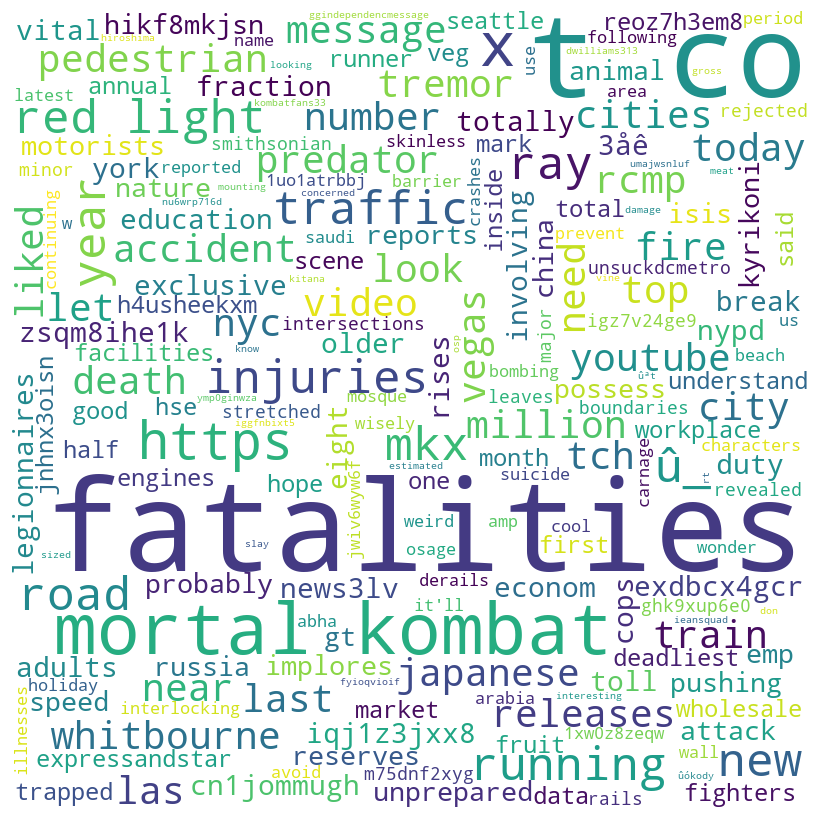

In [7]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords= STOPWORDS,
                min_font_size = 10).generate(text)
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [8]:
from datasets import Dataset,DatasetDict
ds = Dataset.from_pandas(tweets_train)
display(ds)

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'target'],
    num_rows: 7613
})

In [9]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
model_nm = 'microsoft/deberta-v3-small'
tokz = AutoTokenizer.from_pretrained(model_nm, use_fast=False)

In [11]:
ds[0]['text']

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [12]:
tokz.tokenize(ds[0]['text'])

['▁Our',
 '▁Deeds',
 '▁are',
 '▁the',
 '▁Reason',
 '▁of',
 '▁this',
 '▁#',
 'earthquake',
 '▁May',
 '▁ALL',
 'AH',
 '▁Forgive',
 '▁us',
 '▁all']

In [13]:
def tok_func(x): return tokz(x["text"])

tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/7613 [00:00<?, ? examples/s]

In [14]:
tok_ds

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'target', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7613
})

In [17]:
row = tok_ds[0]
row['text'], row['input_ids']

('Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 [1,
  581,
  65453,
  281,
  262,
  18037,
  265,
  291,
  953,
  117831,
  903,
  4924,
  17018,
  43632,
  381,
  305,
  2])

In [22]:
tokz.vocab['▁Forgive']

43632